In [43]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns


In [44]:
mobi_data = pd.read_csv("../data/Mobi_System_Data_2020.csv", compression='zip').dropna()
geo_data = pd.read_csv('../data/geocodings.csv',index_col=0)
data = mobi_data.merge(geo_data.rename({'lat':'Departure lat','long':'Departure long'},axis=1),left_on='Departure station',right_on='address').drop('address',axis=1)
data = data.merge(geo_data.rename({'lat':'Return lat','long':'Return long'},axis=1),left_on='Return station',right_on='address').drop('address',axis=1)
data.shape
# data = data.loc[data["Departure postal code"].str.startswith("V6")]
print(data.columns)
data["time"] = pd.to_datetime(data["Departure"], format="%Y-%m-%d %H:%M:%S")
data["hour"] = data["time"].dt.hour
data["day"] = data["time"].dt.day
data["month"] = data["time"].dt.month
data["year"] = data["time"].dt.year

# train_data = data[["year", "month", "day", "hour", "Departure lat", "Departure long"]]
features_departure = ["year", "month", "day", "hour", "Departure lat", "Departure long"]
train_data = data.groupby(features_departure).size().reset_index(name='counts')
x = train_data[features_departure]
y = train_data["counts"]



Index(['Unnamed: 0', 'Departure', 'Return', 'Bike', 'Departure station',
       'Return station', 'Membership type', 'Covered distance (m)',
       'Duration (sec.)', 'Departure battery voltage (mV)',
       'Return battery voltage (mV)', 'Departure temperature (C)',
       'Return temperature (C)', 'Stopover duration (sec.)',
       'Number of stopovers', 'postal_code_x', 'Departure lat',
       'Departure long', 'postal_code_y', 'Return lat', 'Return long'],
      dtype='object')


In [45]:
stations = data[["Departure lat", "Departure long", "Departure station"]].drop_duplicates()
predict_data_departure = pd.DataFrame(data={
    "year": [], 
    "month": [], 
    "day": [], 
    "hour": [], 
    "Departure lat": [],
    "Departure long": []})
for row in stations.iterrows():
    time = pd.date_range('2021-01-01', periods=8760, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour
    station_data["day"] = station_data["time"].dt.day
    station_data["month"] = station_data["time"].dt.month
    station_data["year"] = station_data["time"].dt.year
    station_data["Departure lat"] = row[1]["Departure lat"]
    station_data["Departure long"] = row[1]["Departure long"]
    station_data["Departure station"] = row[1]["Departure station"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_departure = pd.concat([predict_data_departure, station_data])
predict_data_departure[["year", "month", "day", "hour"]] = predict_data_departure[["year", "month", "day", "hour"]].astype(int)
    



In [46]:
from xgboost import XGBRegressor
model_departure = XGBRegressor()
model_departure.fit(x, y)
predict_data_departure["counts"] = model_departure.predict(predict_data_departure[features_departure])


<AxesSubplot:title={'center':'# of Departure for each hour'}, xlabel='hour'>

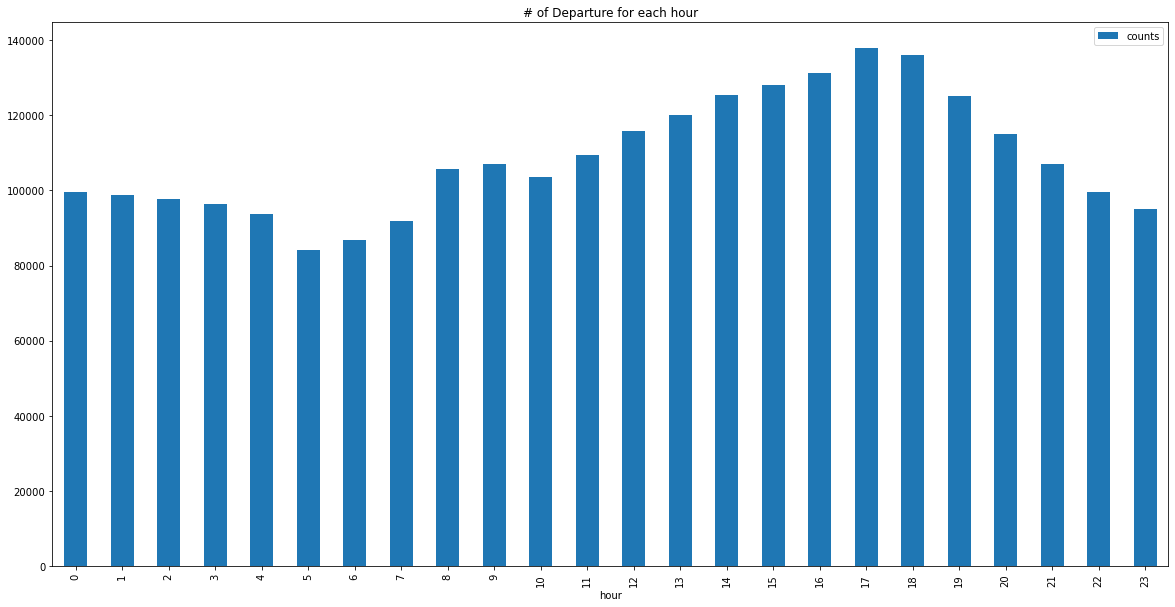

In [47]:
hours = predict_data_departure[["hour", "counts"]].groupby("hour").sum()
# hours.plot.line(figsize=(20, 10)).set_ylabel("# of bikes");
hours.plot(kind='bar', figsize=(20, 10), title="# of Departure for each hour")
# print(hours)

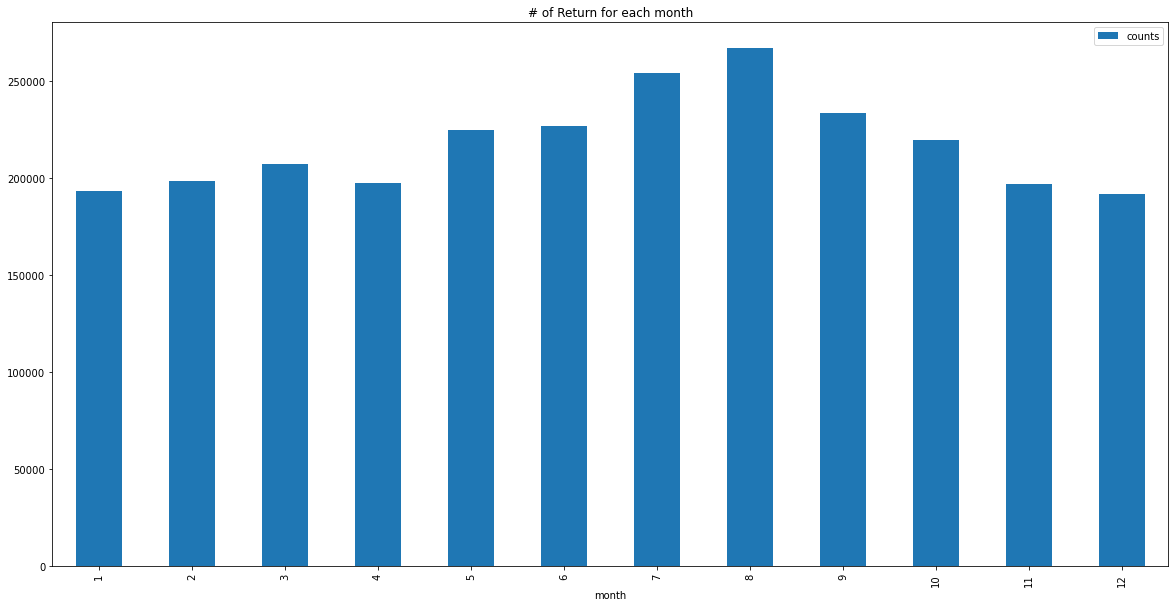

In [48]:
month = predict_data_departure[["month", "counts"]].groupby("month").sum()
month.plot(kind='bar', figsize=(20, 10), title="# of Return for each month");

[Text(0.5, 1.0, 'Top 10 departure stations')]

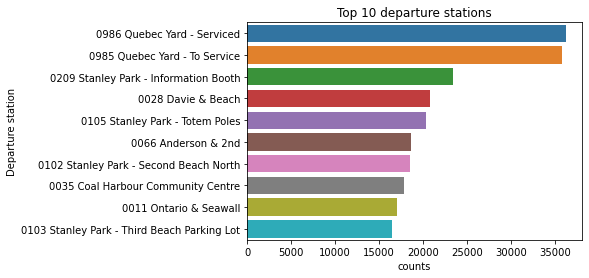

In [49]:
stations = predict_data_departure[["Departure station", "counts"]].groupby("Departure station").sum().reset_index()
stations = stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="Departure station", data=stations)
ax.set(title="Top 10 departure stations")
# stations.sort_values(by="counts", ascending= False).head(10).plot(kind='bar', figsize=(20, 10));

In [50]:
features_return = ["year", "month", "day", "hour", "Return lat", "Return long"]
train_data = data.groupby(features_return).size().reset_index(name='counts')
x = train_data[features_return]
y = train_data["counts"]

stations = data[["Return lat", "Return long", "Return station"]].drop_duplicates()
print(stations)
predict_data_return = pd.DataFrame(data={
    "year": [], 
    "month": [], 
    "day": [], 
    "hour": [], 
    "Return lat": [],
    "Return long": []})
for row in stations.iterrows():
    time = pd.date_range('2021-01-01', periods=8760, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour
    station_data["day"] = station_data["time"].dt.day
    station_data["month"] = station_data["time"].dt.month
    station_data["year"] = station_data["time"].dt.year
    station_data["Return lat"] = row[1]["Return lat"]
    station_data["Return long"] = row[1]["Return long"]
    station_data["Return station"] = row[1]["Return station"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_return = pd.concat([predict_data_return, station_data])
predict_data_return[["year", "month", "day", "hour"]] = predict_data_return[["year", "month", "day", "hour"]].astype(int)

model_return = XGBRegressor()
model_return.fit(x, y)
predict_data_return["counts"] = model_return.predict(predict_data_return[features_return])
print(predict_data_return)

        Return lat  Return long                      Return station
0        49.277213  -123.129625                 0196 Drake & Hornby
5055     49.283290  -123.137034            0087 Broughton & Burnaby
6932     49.278210  -123.136972                 0083 Aquatic Centre
15279    49.265089  -123.119425                  0081 7th & Heather
18552    49.280149  -123.127601             0039 Helmcken & Burrard
...            ...          ...                                 ...
571356   49.267120  -123.109370  0165 Columbia & 4th - TEMP REMOVED
571410   43.390667   -79.763537    0981 Workshop - Service Complete
571497   45.506058   -73.563392       0985 Quebec Yard - To Service
571567   45.971435   -73.483220         0986 Quebec Yard - Serviced
571571   49.021526  -122.383601       0985 Yard - Long Term Storage

[221 rows x 3 columns]
      year  month  day  hour  Return lat  Return long  \
0     2021      1    1     0   49.277213  -123.129625   
1     2021      1    1     1   49.277213  -123

<AxesSubplot:title={'center':'# of Return for each hour'}, xlabel='hour'>

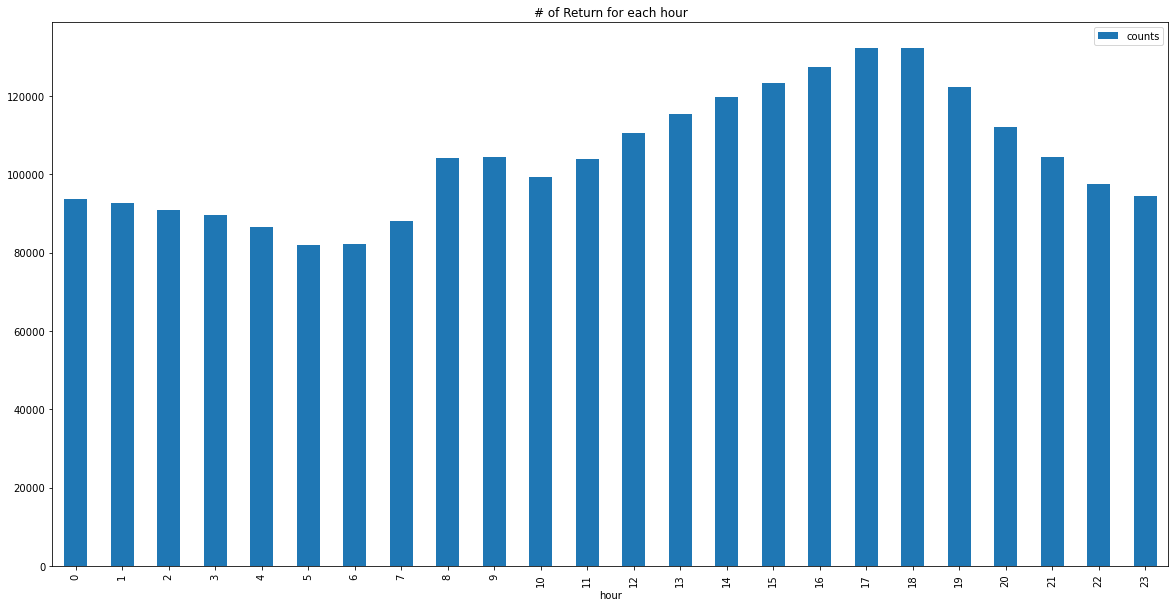

In [51]:
hours = predict_data_return[["hour", "counts"]].groupby("hour").sum()
# hours.plot.line(figsize=(20, 10)).set_ylabel("# of bikes");
hours.plot(kind='bar', figsize=(20, 10), title="# of Return for each hour")
# print(hours)

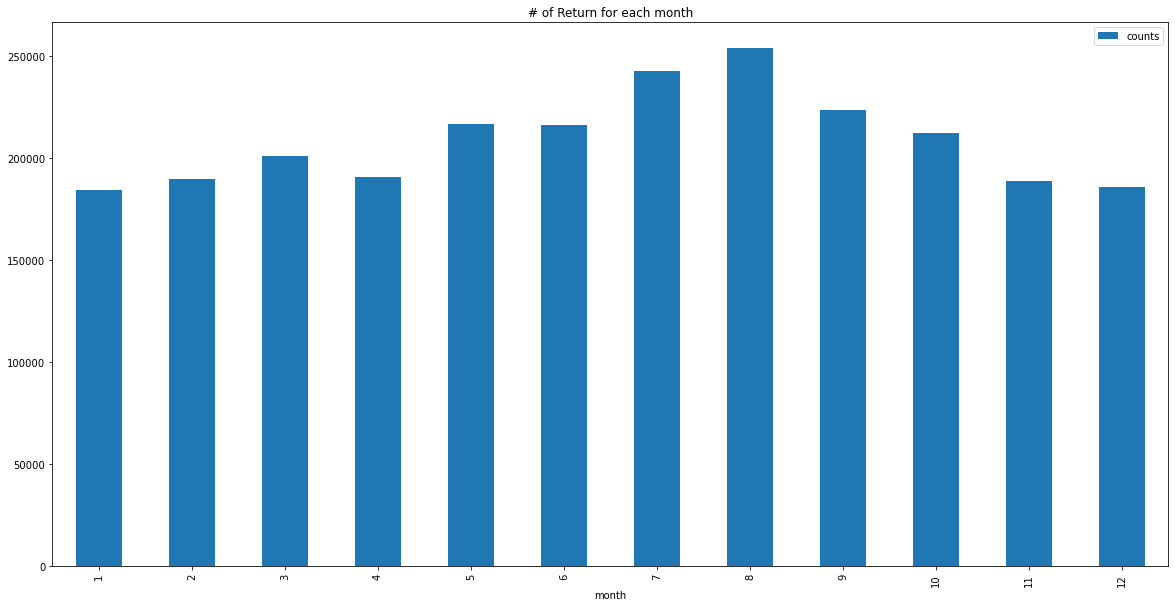

In [52]:
month = predict_data_return[["month", "counts"]].groupby("month").sum()
month.plot(kind='bar', figsize=(20, 10), title="# of Return for each month");

[Text(0.5, 1.0, 'Top 10 return stations')]

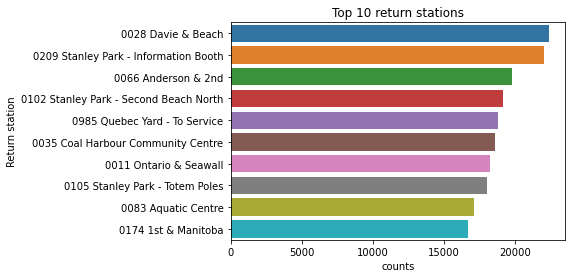

In [53]:
stations = predict_data_return[["Return station", "counts"]].groupby("Return station").sum().reset_index()
stations = stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="Return station", data=stations)
ax.set(title='Top 10 return stations')

In [54]:
# mobi_data = pd.read_csv("../data/Mobi_System_Data_2021.csv", compression='zip').dropna()
# geo_data = pd.read_csv('../data/geocodings.csv',index_col=0)
# test_data = mobi_data.merge(geo_data.rename({'lat':'Departure lat','long':'Departure long'},axis=1),left_on='Departure station',right_on='address').drop('address',axis=1)
# test_data = test_data.merge(geo_data.rename({'lat':'Return lat','long':'Return long'},axis=1),left_on='Return station',right_on='address').drop('address',axis=1)
# # data = data.loc[data["Departure postal code"].str.startswith("V6")]
# test_data["time"] = pd.to_datetime(test_data["Departure"], format="%Y-%m-%d %H:%M:%S")
# test_data["hour"] = test_data["time"].dt.hour
# test_data["day"] = test_data["time"].dt.day
# test_data["month"] = test_data["time"].dt.month
# test_data["year"] = test_data["time"].dt.year

# # train_data = test_data[["year", "month", "day", "hour", "Departure lat", "Departure long"]]
# features_departure = ["year", "month", "day", "hour", "Departure lat", "Departure long"]
# departure_test_data = test_data.groupby(features_departure).size().reset_index(name='counts')
# return_test_data = test_data.groupby(features_return).size().reset_index(name='counts')

# stations_departure = departure_test_data[["Departure station", "counts"]].groupby("Departure station").sum().reset_index()
# stations_return = return_test_data[["Return station", "counts"]].groupby("Return station").sum().reset_index()